# VGG网络  

### 1. VGG块  
由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。在最初的VGG论文中 (Simonyan and Zisserman, 2014)，作者使用了带有3 × 3卷积核、填充为2（保持高度和宽度）的卷积层，和带有2 × 2汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层。在下面的代码中，我们定义了一个名为vgg_block的函数来实现一个VGG块。该函数有三个参数，分别对应于卷积层的数量num_convs、输入通道的数量in_channels 和输出通道的数量out_channels.   

In [4]:
import torch
from torch import nn
from Image_dataset_read_learning import load_data_fashion_mnist
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layer = []
    # 各个VGG块的输出将图片高宽各自减半
    for _ in range(num_convs):
        layer.append(nn.Conv2d(in_channels, out_channels, 
                               kernel_size=3, padding=1))
        layer.append(nn.ReLU())
        in_channels = out_channels
    layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layer)

### VGG网络  
与AlexNet、 LeNet一样， VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连
接层组成。如 图7.2.1中所示。  
![VGGNet](picture\VGGNet.jpg)  

VGG神经网络连接 图7.2.1的几个VGG块（在vgg_block函数中定义）。其中有超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。  

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。第一个模块有64个
输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG‐11。

In [5]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_conv, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_conv, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(), 
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5), 
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), 
        nn.Linear(4096, 10)
    )
net = vgg(conv_arch)

接下来，我们将构建一个高度和宽度为224的单通道数据样本，以观察每个层输出的形状。

In [6]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


由于VGG‐11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion‐MNIST数据集。  

In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.185, train acc 0.931, test acc 0.916
716.9 examples/sec on cuda:0


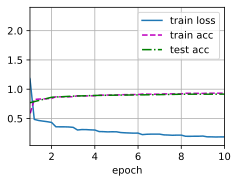

In [8]:
# 学习率率高，batch_size减小以减少内存消耗
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 总结  
- LeNet (1995)
    - 2 卷积 + 池化层
    - 2 全连接层
- AlexNet
    - 更大更深
    - ReLu, Dropout, 数据增强
- VGG
    - 更大更深的AlexNet